## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression


## Load data

In [2]:
data_xlsx = pd.ExcelFile('data.xlsx')
co2_df = pd.read_excel(data_xlsx, 0)
temp_df = pd.read_excel(data_xlsx, 1)


In [3]:
co2_df.columns = ['year', 'y']
temp_df.columns = ['year', 'y']


In [4]:
co2_df

,year,y
0,1959,315.98
1,1960,316.91
2,1961,317.64
3,1962,318.45
4,1963,318.99
...,...,...
58,2017,406.76
59,2018,408.72
60,2019,411.66
61,2020,414.24


## Graphing & Pre-Analysis

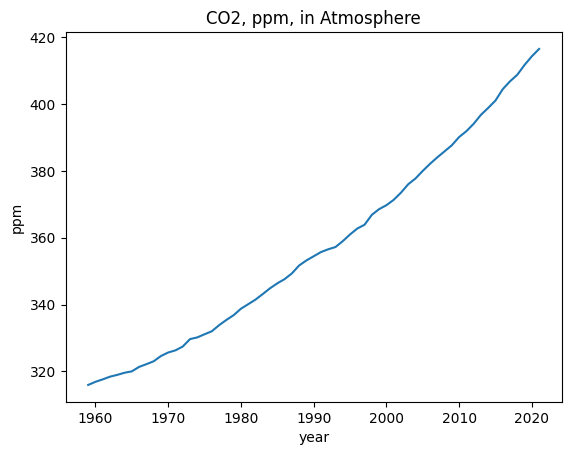

In [5]:
g_co2 = co2_df.plot(x='year', y='y', ylabel='ppm', title='CO2, ppm, in Atmosphere', legend=None)


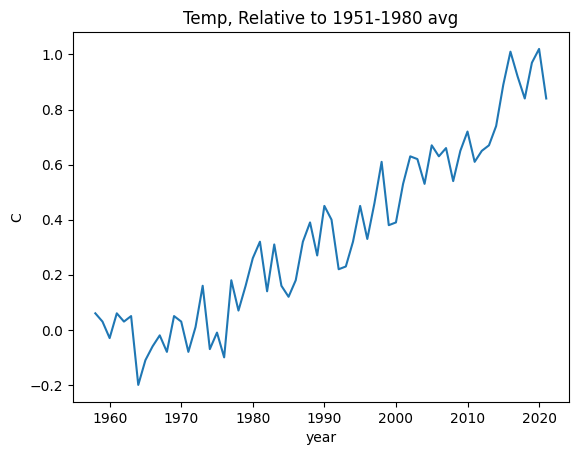

In [6]:
g_temp = temp_df.plot(x='year', y='y', ylabel='C', title='Temp, Relative to 1951-1980 avg', legend=None)


In [7]:
ct_df = pd.concat([co2_df['y'], temp_df['y']], axis=1, keys=['co2', 'temp'])
ct_df = ct_df[:-1]


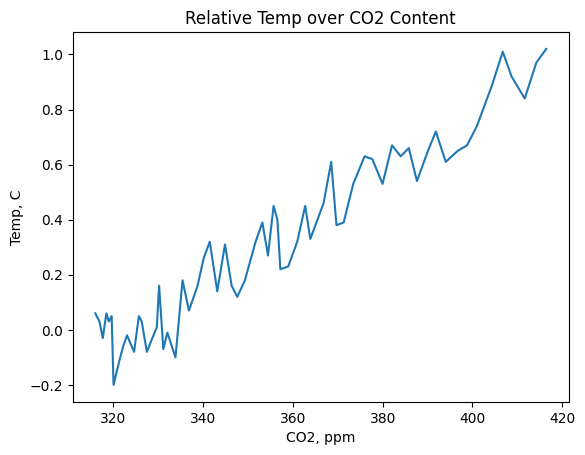

In [8]:
g_ct = ct_df.plot(x='co2', y='temp', xlabel='CO2, ppm', ylabel='Temp, C', title='Relative Temp over CO2 Content', legend=None)


## Simple Bi variate Analysis

In [9]:
m_lr = LinearRegression()
m_lr.fit(ct_df[['co2']], ct_df[['temp']])

pred = m_lr.predict(ct_df[['co2']])


In [10]:
pmcc = ct_df.corr()["temp"][0]
coef = m_lr.coef_[0][0]
itcp = m_lr.intercept_[0]

print(
        f'PMCC: {pmcc} \n'
        f'R^2: {pmcc**2} \n'
        f'Linear Regressed: y = {coef}x {"+" if abs(itcp) == itcp else "-"} {abs(itcp)}'
)


PMCC: 0.9599812208926525 
R^2: 0.9215639444665477 
Linear Regressed: y = 0.010330473207293444x - 3.352746379345213


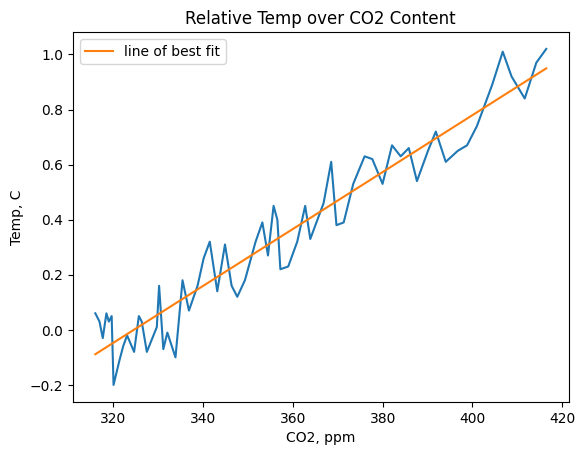

In [11]:
plt.plot(ct_df[['co2']], ct_df[['temp']])
plt.plot(ct_df[['co2']], pred, label='line of best fit')
plt.title('Relative Temp over CO2 Content')
plt.ylabel('Temp, C')
plt.xlabel('CO2, ppm')
plt.legend()
plt.show()


## CO_2 Forecasting Models

# arima

<AxesSubplot: title={'center': 'CO2 Arima Forecast 2022-2050'}, xlabel='date', ylabel='ppm'>

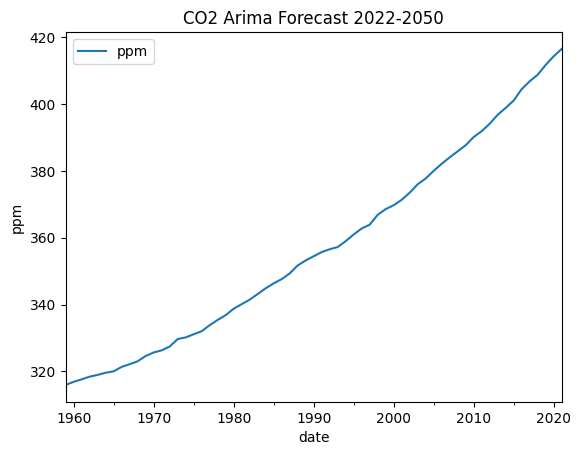

In [12]:
import statsmodels.api as sm
import statsmodels.tsa.statespace.sarimax as sarima
from statsmodels.tsa.stattools import adfuller

co2_arima = co2_df.copy()
co2_arima.columns = ['date', 'ppm']
co2_arima['date'] = pd.to_datetime(co2_arima.date, format='%Y')
co2_arima.plot(x='date', y='ppm', xlabel='date', ylabel='ppm', title='CO2 Arima Forecast 2022-2050')

In [13]:
# p-value NOT <= 0.05 hence it is non-stationary
# Stationarity - The statistical properties of a time series, process generating it do not change overtime
stationary = adfuller(co2_arima['ppm'])
stationary

(5.588259302435865,
 1.0,
 2,
 60,
 {'1%': -3.5443688564814813,
  '5%': -2.9110731481481484,
  '10%': -2.5931902777777776},
 69.40020639043743)

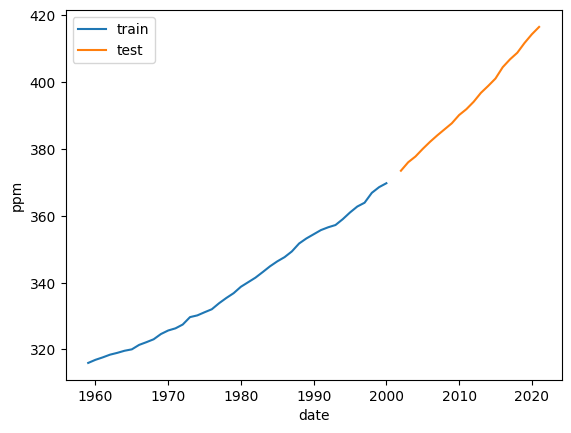

In [14]:
# (this part is for looking at model accuracies later on, ignore for now)
# checking whether first 42 data records can accurately generate last 20 data records
train = co2_arima[:42]
test = co2_arima[-20:]

plt.plot(train['date'], train['ppm'], label='train')
plt.plot(test['date'], test['ppm'], label='test')
plt.xlabel('date')
plt.ylabel('ppm')
plt.legend()

In [15]:
# grid search, exploring different param combinations


# exponential

In [16]:
from scipy.optimize import curve_fit


In [17]:
PRED_YEARS = pd.DataFrame(range(1959, 2051))

In [18]:
def expo_func(x, a, b, c, d):
        return a**(x * b + c) + d


In [19]:
pmt, cov = curve_fit(expo_func, co2_df['year'], co2_df['y'])
print(pmt)
print(cov)


[ 1.00571737e+00  2.84266152e+00 -4.85438646e+03  2.56024004e+02]
[[ 1.04860015e+02 -5.19885599e+04  8.87805151e+07 -4.92522722e+00]
 [-5.19885599e+04  2.57754147e+07 -4.40165028e+10  2.44203827e+03]
 [ 8.87805151e+07 -4.40165028e+10  7.51666866e+13 -4.17030800e+06]
 [-4.92518315e+00  2.44201642e+03 -4.17027068e+06  5.91488324e+00]]


In [20]:
co2_pred_exp_df = expo_func(PRED_YEARS, *pmt)
co2_pred_exp_df.columns = ['y']

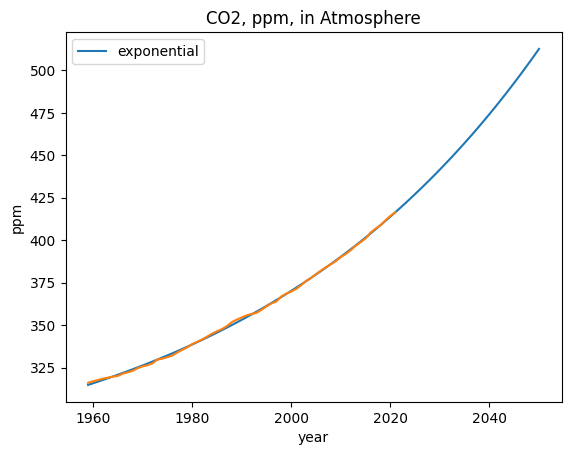

In [21]:
plt.plot(PRED_YEARS, co2_pred_exp_df, label='exponential')
plt.plot(co2_df[['year']], co2_df[['y']])
plt.title('CO2, ppm, in Atmosphere')
plt.ylabel('ppm')
plt.xlabel('year')
plt.legend()
plt.show()


In [22]:
co2_pred_pmcc = co2_df['y'].corr(co2_pred_exp_df['y'])

print(
        f'PMCC: {co2_pred_pmcc} \n'
        f'R^2: {co2_pred_pmcc**2} \n'
        f'Exponential Regressed: y = {pmt[0]:.6f}^({pmt[1]:.4f}x - {abs(pmt[2]):.1f}) + {pmt[3]:.3f}'
)

PMCC: 0.9997258887013534 
R^2: 0.9994518525397108 
Exponential Regressed: y = 1.005717^(2.8427x - 4854.4) + 256.024


# prophet

In [23]:
from prophet import Prophet


Importing plotly failed. Interactive plots will not work.


In [24]:
co2_df2 = co2_df.copy()
co2_df2.columns = ['ds', 'y']
co2_df2['ds'] = pd.to_datetime(co2_df2.ds, format='%Y')


In [25]:
co2_df2

,ds,y
0,1959-01-01,315.98
1,1960-01-01,316.91
2,1961-01-01,317.64
3,1962-01-01,318.45
4,1963-01-01,318.99
...,...,...
58,2017-01-01,406.76
59,2018-01-01,408.72
60,2019-01-01,411.66
61,2020-01-01,414.24


In [26]:
P = Prophet(yearly_seasonality=False)
P.fit(co2_df2)


21:25:00 - cmdstanpy - INFO - Chain [1] start processing
21:25:00 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
future_df = P.make_future_dataframe(periods=30, freq='Y')
future_df


,ds
0,1959-01-01
1,1960-01-01
2,1961-01-01
3,1962-01-01
4,1963-01-01
...,...
88,2046-12-31
89,2047-12-31
90,2048-12-31
91,2049-12-31


In [28]:
forecast_df = P.predict(future_df)
forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1959-01-01,316.154264,315.762790,316.574596,316.154264,316.154264,0.0,0.0,0.0,0.0,0.0,0.0,316.154264
1,1960-01-01,316.852419,316.459817,317.269565,316.852419,316.852419,0.0,0.0,0.0,0.0,0.0,0.0,316.852419
2,1961-01-01,317.552487,317.127057,317.940655,317.552487,317.552487,0.0,0.0,0.0,0.0,0.0,0.0,317.552487
3,1962-01-01,318.244058,317.802142,318.662781,318.244058,318.244058,0.0,0.0,0.0,0.0,0.0,0.0,318.244058
4,1963-01-01,318.935629,318.512604,319.387995,318.935629,318.935629,0.0,0.0,0.0,0.0,0.0,0.0,318.935629
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,2046-12-31,478.042718,464.445774,491.495481,464.492981,491.584725,0.0,0.0,0.0,0.0,0.0,0.0,478.042718
89,2047-12-31,480.423255,466.048048,494.461344,465.875364,494.479568,0.0,0.0,0.0,0.0,0.0,0.0,480.423255
90,2048-12-31,482.810313,467.505518,497.349955,467.607139,497.411190,0.0,0.0,0.0,0.0,0.0,0.0,482.810313
91,2049-12-31,485.190850,469.023422,500.609299,469.179969,500.624646,0.0,0.0,0.0,0.0,0.0,0.0,485.190850


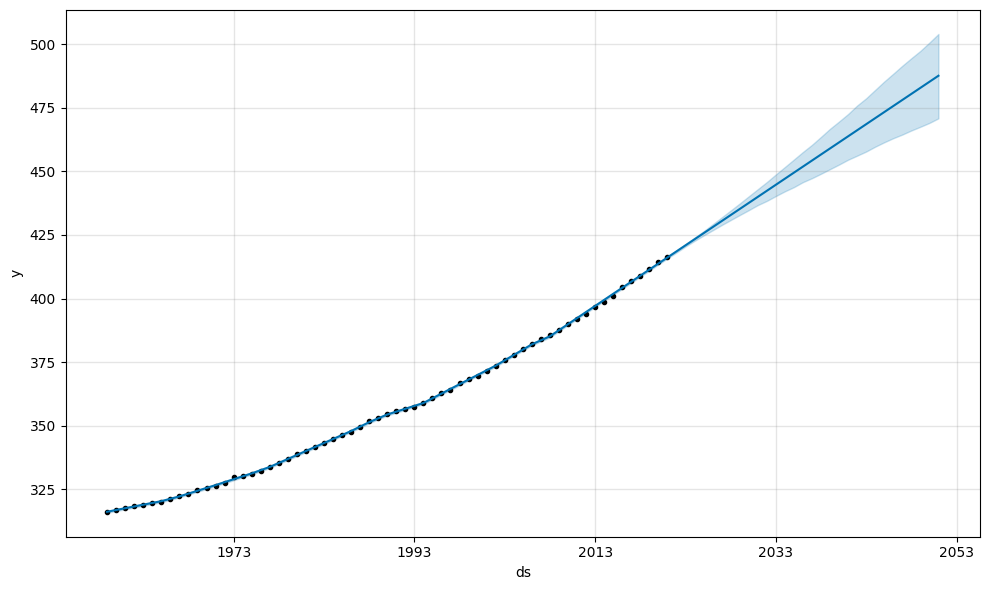

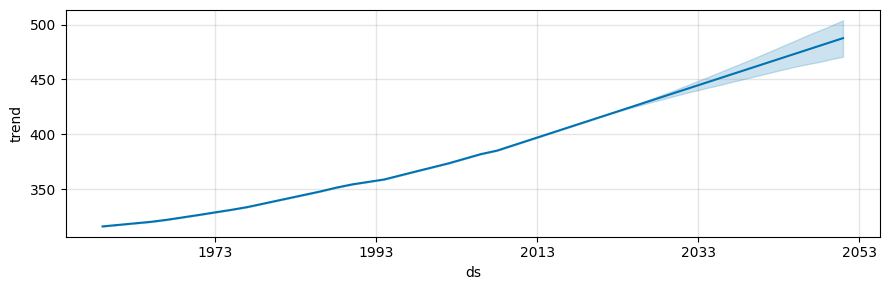

In [29]:
fig = P.plot(forecast_df)
fig2 = P.plot_components(forecast_df)


In [30]:
co2_pred_prophet_df = forecast_df
co2_pred_prophet_df = co2_pred_prophet_df[['ds', 'yhat']]
co2_pred_prophet_df.columns = ['year', 'y']


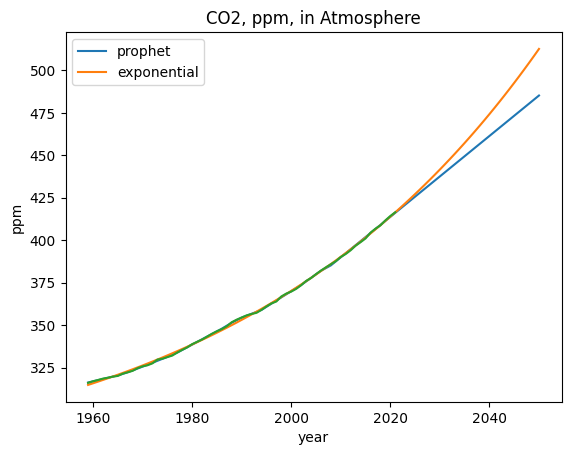

In [31]:
plt.plot(PRED_YEARS, co2_pred_prophet_df[['y']][:-1], label='prophet')
plt.plot(PRED_YEARS, co2_pred_exp_df, label='exponential')
plt.plot(co2_df[['year']], co2_df[['y']])
plt.title('CO2, ppm, in Atmosphere')
plt.ylabel('ppm')
plt.xlabel('year')
plt.legend()
plt.show()


In [32]:
co2_pred_prophet_pmcc = co2_df['y'].corr(co2_pred_prophet_df['y'])

print(
        f'PMCC: {co2_pred_prophet_pmcc} \n'
        f'R^2: {co2_pred_prophet_pmcc**2} \n'
)


PMCC: 0.9999412069035434 
R^2: 0.999882417263715 



## Temperature Predictions

In [33]:
M3 = temp_df.copy()
M3.columns = ['ds', 'y']
M3['ds'] = pd.to_datetime(M3.ds, format='%Y')

In [34]:
P = Prophet(yearly_seasonality=False)
P.fit(M3)


21:25:01 - cmdstanpy - INFO - Chain [1] start processing
21:25:01 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
future_df = P.make_future_dataframe(periods=30, freq='Y')
forecast_df = P.predict(future_df)


In [36]:
temp_pred_prophet_df = forecast_df[['ds', 'yhat']]
temp_pred_prophet_df.columns = ['year', 'y']
temp_pred_prophet_df

,year,y
0,1958-01-01,-0.170764
1,1959-01-01,-0.154395
2,1960-01-01,-0.138025
3,1961-01-01,-0.121610
4,1962-01-01,-0.105240
...,...,...
89,2046-12-31,1.295877
90,2047-12-31,1.312397
91,2048-12-31,1.328962
92,2049-12-31,1.345482


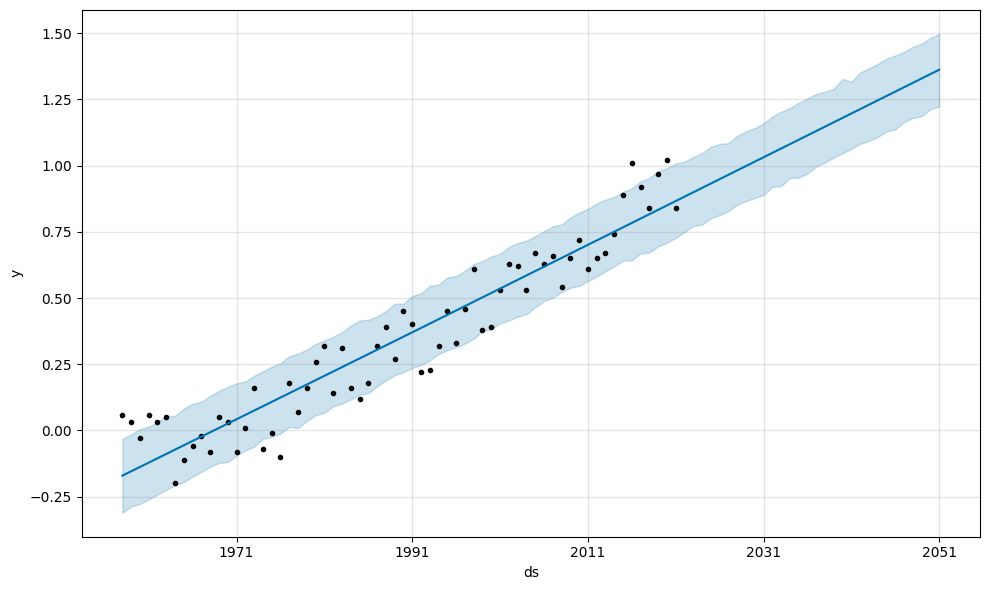

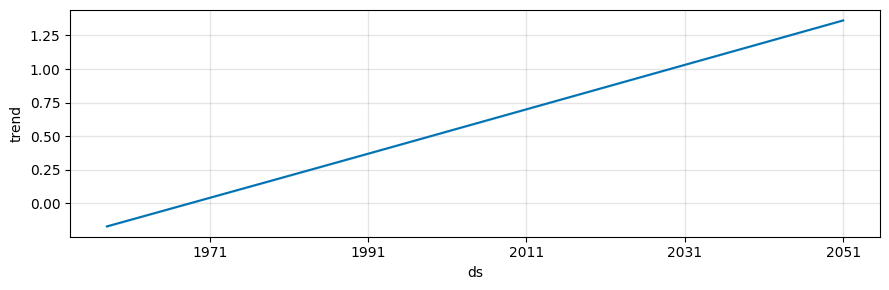

In [37]:
fig3 = P.plot(forecast_df)
fig4 = P.plot_components(forecast_df)

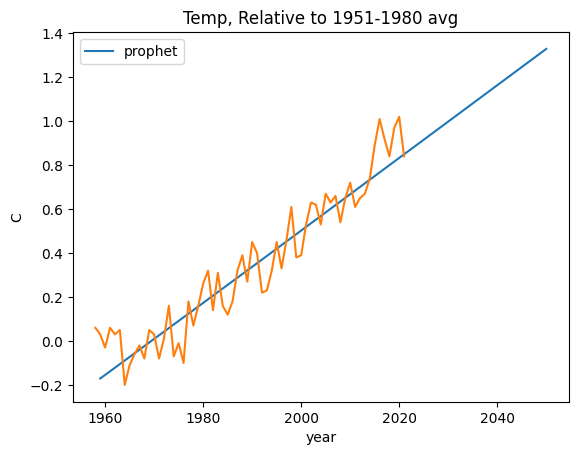

In [38]:
plt.plot(PRED_YEARS, temp_pred_prophet_df[['y']][:-2], label='prophet')
plt.plot(temp_df[['year']], temp_df[['y']])
plt.title('Temp, Relative to 1951-1980 avg')
plt.ylabel('C')
plt.xlabel('year')
plt.legend()
plt.show()
